In [1]:
import pandas as pd
import numpy as np

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


In [2]:
import sys

In [3]:
sys.path.append("../code/")

In [4]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

### Weight per appliance

Homes having good score on HVAC should be favoured. 

In [5]:
weights = {"hvac":0.4, 'fridge':0.2,'light':0.15,'dr':0.1,'wm':0.05,'dw':0.1}

In [8]:
np.sum(weights.values())==1

True

In [9]:
df.columns

Index([u'aggregate_1', u'aggregate_2', u'aggregate_3', u'aggregate_4',
       u'aggregate_5', u'aggregate_6', u'aggregate_7', u'aggregate_8',
       u'aggregate_9', u'aggregate_10', 
       ...
       u'total_occupants', u'variance', u'ratio_min_max',
       u'difference_min_max', u'ratio_difference_min_max', u'skew',
       u'kurtosis', u'p_25', u'p_50', u'p_75'],
      dtype='object', length=171)

### Best features

In [10]:
best_features = {'hvac':['aggregate_7','aggregate_9','p_75'],
                'fridge':['area','kurtosis','difference_min_max'],
                'wm':['area','num_rooms'],
                'light':['area'],
                'dr':['total_occupants','area'],
                'dw':['aggregate_12','aggregate_1']}

In [17]:
from sklearn.cluster import KMeans

In [344]:
appliance="fridge"
k=7


In [345]:
labels = clf.labels_
count = pd.value_counts(labels)

AttributeError: 'KNeighborsRegressor' object has no attribute 'labels_'

In [346]:
count_to_use = count[count>3]
count_to_use

0    13
1     8
3     6
2     5
dtype: int64

In [347]:
centroids = pd.DataFrame(clf.cluster_centers_)
centroids.columns = dfa.columns

AttributeError: 'KNeighborsRegressor' object has no attribute 'cluster_centers_'

In [348]:
centroids

,total_occupants,area
0,0.323077,0.277862
1,0.825000,0.496161
3,0.400000,0.670735
2,0.520000,0.080236


In [349]:
centroids = centroids.ix[count_to_use.index]
#centroids.index = range(len(count_to_use))
centroids

,total_occupants,area
0,0.323077,0.277862
1,0.825000,0.496161
3,0.400000,0.670735
2,0.520000,0.080236


In [350]:
score = {}
for appliance in all_homes.keys():
    np.random.seed(42)
    print appliance
    score[appliance]={}
    dfa = df.ix[all_homes[appliance]][best_features[appliance]]
    clf = KMeans(n_clusters=k)
    clf.fit(dfa)
    labels = clf.labels_
    count = pd.value_counts(labels)
    count_to_use = count[count>3]
    centroids = pd.DataFrame(clf.cluster_centers_)
    centroids.columns = dfa.columns
    centroids = centroids.ix[count_to_use.index]

    for home in dfa.index:
        di = np.sqrt(np.square(centroids-dfa.ix[home]).sum(axis=1))
        cluster_closest = di.argmin()
        distance = di.ix[cluster_closest]
        #score[appliance][home] = (1.0/(distance+0.1))
        score[appliance][home] = (1.0/(distance+0.1))*(len(all_homes[appliance])/(count_to_use.ix[cluster_closest])*0.5)
    score[appliance] = pd.Series(score[appliance])
    score[appliance].sort()
    score[appliance]=scale_min_max(score[appliance],0,1)

hvac
light
wm
fridge
dw
dr


In [351]:
import seaborn as sns

In [352]:
%matplotlib inline

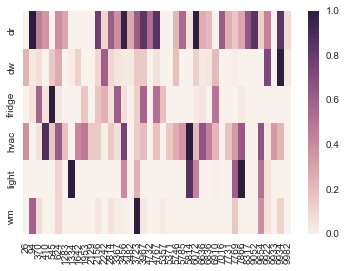

In [539]:
sns.heatmap(pd.DataFrame(score).fillna(0).T)

In [354]:
score_df = pd.DataFrame(score).fillna(0)

In [355]:
def scale_min_max(ser, minimum=-1, maximum=1):
    ser_min = ser.min()
    ser_max = ser.max()
    return minimum + ((maximum-minimum)*(ser-ser_min))/(ser_max-ser_min)


In [358]:
a=score_df[appliance].copy()
a.sort()

In [359]:
N_HOMES=7

In [360]:
train_homes = a.tail(N_HOMES).index.values

In [361]:
train_homes

array([9922, 7866, 9934, 3967, 4767, 7016, 9052])

In [362]:
test_homes = np.array([x for x in df.ix[all_homes["hvac"]].index if x not in train_homes])

In [511]:
from all_functions import *
from features import *

In [512]:
def predict_train_homes(train_homes, test_homes, appliance, feature):
    from sklearn.cross_validation import LeaveOneOut
    from sklearn.ensemble import ExtraTreesRegressor

   

    K_min, K_max = 1,6
    F_min, F_max=1,8

    out = {}
    appliance_df = df.ix[all_homes[appliance]]
    train_homes_df = appliance_df.ix[train_homes]
    test_homes_df = appliance_df.ix[test_homes]
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    l = LeaveOneOut(len(train_homes))
    for cv_train, cv_test in l:
        cv_train_home =appliance_df.ix[train_homes[cv_train]]
        cv_test_home = appliance_df.ix[train_homes[cv_test]]
        test_home_name = cv_test_home.index.values[0]
        Y = cv_train_home[['%s_%d' %(appliance, i) for i in range(start, stop)]].sum(axis=1).values
        forest = ExtraTreesRegressor(n_estimators=250,
                                          random_state=0)
        forest.fit(cv_train_home[feature_map[feature]], Y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Now varying K and top-N features
        out[test_home_name] ={}
        for K in range(K_min, K_max):
            out[test_home_name][K]={}
            for top_n in range(F_min,F_max):
                out[test_home_name][K][top_n]=[]
                top_n_features = cv_train_home[feature_map[feature]].columns[indices][:top_n]

                # Now fitting KNN on this
                for month in range(start, stop):
                    clf = KNeighborsRegressor(n_neighbors=K)
                    clf.fit(cv_train_home[top_n_features], cv_train_home['%s_%d' %(appliance, month)])
                    out[test_home_name][K][top_n].append(clf.predict(cv_test_home[top_n_features]))

    accur = {}

    for K in range(K_min, K_max):
        accur[K] = {}
        for top_n in range(F_min, F_max):
            temp = {}
            for h in out.iterkeys():
                pred = pd.DataFrame(out[h][K][top_n]).T
                #all_but_h = [x for x in out.keys() if x!=h]
                pred.index = [h]
                pred.columns = [['%s_%d' %(appliance, i) for i in range(start, stop)]]
                gt = appliance_df.ix[h][['%s_%d' %(appliance, i) for i in range(start, stop)]]
                error = (pred-gt).abs().div(gt).mul(100)
                mean_error = error.mean().mean()
                a = 100-mean_error
                if a<0:
                    a=0
                temp[h]=a
            ac = pd.Series(temp).mean()

            accur[K][top_n] = ac

    accur_df = pd.DataFrame(accur)
    accur_max = accur_df.max().max()
    max_ac_df = accur_df[accur_df==accur_max]
    F_best = cv_train_home[feature_map[feature]].columns[indices][:max_ac_df.mean(axis=1).dropna().index.values[0]].tolist()
    K_best = max_ac_df.mean().dropna().index.values[0]

    out_overall={}
    pred_test = {}
    gt_test = {}
    for month in range(start, stop):
        clf = KNeighborsRegressor(n_neighbors=K_best)
        clf.fit(train_homes_df[F_best], train_homes_df['%s_%d' %(appliance, month)])
        pred_test[month] = clf.predict(test_homes_df[F_best])
        gt_test[month] = test_homes_df['%s_%d' %(appliance, month)]


    #json.dump({'f':F_best, 'k':K_best,'accuracy':accur_max},open("../sensitivity-new/%s_%s_%d.json" %(appliance,feature, home),"w") )

    pred_df = pd.DataFrame(pred_test)
    pred_df.index = test_homes_df.index
    gt_df = pd.DataFrame(gt_test)
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    accuracy_test = 100-error
    accuracy_test[accuracy_test<0]=0
    out_overall=accuracy_test.mean().mean()
    return out_overall, accuracy_test

['aggregate_10', 'aggregate_9']

In [342]:
K_best

1

In [343]:
out_overall

66.553245571940224

In [124]:
import sys
CLUSTER=True
if CLUSTER:
    sys.path.insert(0, '/if6/nb2cz/anaconda/lib/python2.7/site-packages')


import numpy as np
import pandas as pd



from all_functions import *
from features import *

import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import ShuffleSplit

NUM_NEIGHBOUR_MAX = 6
F_MAX = 6

K_min, K_max = 1,6
F_min, F_max=1,8

import json

from sklearn.cross_validation import LeaveOneOut
from sklearn.ensemble import ExtraTreesRegressor



def _find_accuracy_num_homes(appliance, train_homes, feature="Monthly+Static"):
    out = {}
    out_overall={}
    appliance_df = df.ix[all_homes[appliance]]
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_homes = appliance_df.index



        for train, test in rs:
            train_homes = appliance_df.index.values[train]
            test_homes = appliance_df.index.values[test]
            train_homes_df = appliance_df.ix[train_homes]
            test_homes_df = appliance_df.ix[test_homes]

            # Now, we need to do cross validation on train homes
            l = LeaveOneOut(len(train_homes))
            for cv_train, cv_test in l:
                cv_train_home =appliance_df.ix[train_homes[cv_train]]
                cv_test_home = appliance_df.ix[train_homes[cv_test]]
                test_home_name = cv_test_home.index.values[0]
                Y = cv_train_home[['%s_%d' %(appliance, i) for i in range(start, stop)]].sum(axis=1).values
                forest = ExtraTreesRegressor(n_estimators=250,
                                      random_state=0)
                forest.fit(cv_train_home[feature_map[feature]], Y)
                importances = forest.feature_importances_
                indices = np.argsort(importances)[::-1]

                # Now varying K and top-N features
                out[test_home_name] ={}
                for K in range(K_min, K_max):
                    out[test_home_name][K]={}
                    for top_n in range(F_min,F_max):
                        out[test_home_name][K][top_n]=[]
                        top_n_features = cv_train_home[feature_map[feature]].columns[indices][:top_n]

                        # Now fitting KNN on this
                        for month in range(start, stop):
                            clf = KNeighborsRegressor(n_neighbors=K)
                            clf.fit(cv_train_home[top_n_features], cv_train_home['%s_%d' %(appliance, month)])
                            out[test_home_name][K][top_n].append(clf.predict(cv_test_home[top_n_features]))

            accur = {}

            for K in range(K_min, K_max):
                accur[K] = {}
                for top_n in range(F_min, F_max):
                    temp = {}
                    for h in out.iterkeys():
                        pred = pd.DataFrame(out[h][K][top_n]).T
                        #all_but_h = [x for x in out.keys() if x!=h]
                        pred.index = [h]
                        pred.columns = [['%s_%d' %(appliance, i) for i in range(start, stop)]]
                        gt = appliance_df.ix[h][['%s_%d' %(appliance, i) for i in range(start, stop)]]
                        error = (pred-gt).abs().div(gt).mul(100)
                        mean_error = error.mean().mean()
                        a = 100-mean_error
                        if a<0:
                            a=0
                        temp[h]=a
                    ac = pd.Series(temp).mean()

                    accur[K][top_n] = ac

            accur_df = pd.DataFrame(accur)
            accur_max = accur_df.max().max()
            max_ac_df = accur_df[accur_df==accur_max]
            F_best = cv_train_home[feature_map[feature]].columns[indices][:max_ac_df.mean(axis=1).dropna().index.values[0]].tolist()
            K_best = max_ac_df.mean().dropna().index.values[0]

        # Now predicting for test home


        pred_test = {}
        gt_test = {}
        for month in range(start, stop):
            clf = KNeighborsRegressor(n_neighbors=K_best)
            clf.fit(train_homes_df[F_best], train_homes_df['%s_%d' %(appliance, month)])
            pred_test[month] = clf.predict(test_homes_df[F_best])
            gt_test[month] = test_homes_df['%s_%d' %(appliance, month)]


        #json.dump({'f':F_best, 'k':K_best,'accuracy':accur_max},open("../sensitivity-new/%s_%s_%d.json" %(appliance,feature, home),"w") )

        pred_df = pd.DataFrame(pred_test)
        pred_df.index = test_homes_df.index
        gt_df = pd.DataFrame(gt_test)
        error = (gt_df-pred_df).abs().div(gt_df).mul(100)
        accuracy_test = 100-error
        accuracy_test[accuracy_test<0]=0
        out_overall[random_seed]=accuracy_test.mean().mean()


    return pd.Series(out_overall)



import sys
appliance, num_homes, start_seed, end_seed, feature = sys.argv[1], sys.argv[2],sys.argv[3],sys.argv[4],sys.argv[5]
num_homes = int(num_homes)
start_seed=int(start_seed)
end_seed=int(end_seed)
out_df = _find_accuracy_num_homes(appliance, num_homes, start_seed, end_seed, feature)
_save_csv(out_df, "../sensitivity-data-new", appliance, num_homes, start_seed, end_seed, feature)
Status API Training Shop Blog About Pricing
© 2016 GitHub, Inc. Terms Privacy Security Contact Help

,hvac
5357,0.000000
2242,0.029696
9922,0.085511
370,0.139782
3367,0.154597
1283,0.288392
7769,0.315062
5785,0.369766
2129,0.386041
2814,0.388126


In [118]:
scale_min_max(hvac_score, 0, 1)

,hvac
5357,0.000000
2242,0.041038
9922,0.118171
370,0.193172
3367,0.213644
7769,0.290089
6836,0.391409
1283,0.398543
5785,0.510998
2129,0.533489


In [375]:
import matplotlib.pyplot as plt

In [458]:
appliance_df.sum(axis=1)

94      0.610684
370     1.769393
410     0.691539
545     1.445072
624     0.778499
1953    0.823177
2156    0.772223
2242    1.910001
2814    0.970483
3367    1.468789
3456    0.584266
3723    0.782353
3967    1.628365
4767    1.218933
5357    1.138451
5371    0.663031
6072    1.083752
6636    1.122133
6910    1.380586
7769    0.339821
7866    0.570873
dtype: float64

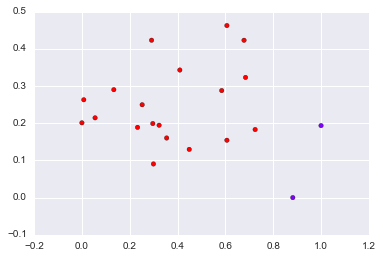

In [452]:
from mst_clustering import MSTClustering
appliance="fridge"
appliance_df = df.ix[all_homes[appliance]][best_features[appliance]]


model = MSTClustering(cutoff_scale=0.3, approximate=False, min_cluster_size=4)

X = appliance_df.values
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow');

In [453]:
labels

array([ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0])

In [454]:
def plot_mst(model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
    for axi, full_graph, colors in zip(ax, [True, False], ['lightblue', model.labels_]):
        segments = model.get_graph_segments(full_graph=full_graph)
        axi.plot(segments[0], segments[1], '-k', zorder=1, lw=1)
        axi.scatter(X[:, 0], X[:, 1], c=colors, cmap=cmap, zorder=2)
        axi.axis('tight')
    
    ax[0].set_title('Full Minimum Spanning Tree', size=16)
    ax[1].set_title('Trimmed Minimum Spanning Tree', size=16);

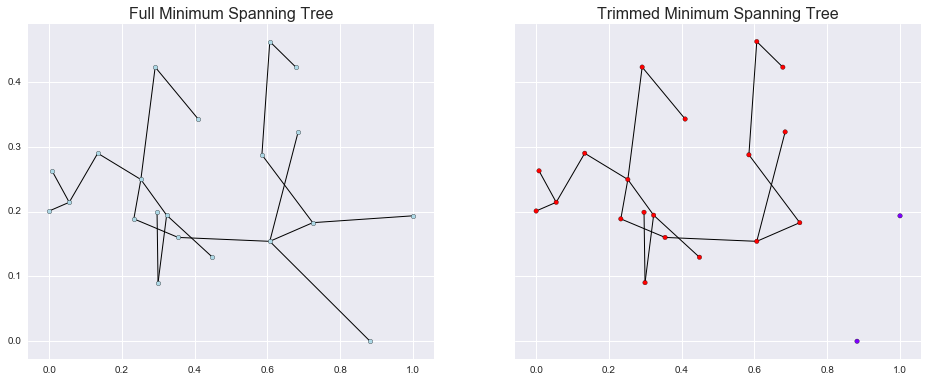

In [455]:
plot_mst(model)


In [415]:
appliance="hvac"
appliance_df = df.ix[all_homes[appliance]][best_features[appliance]]
clf.fit(appliance_df)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
    min_samples=5, p=None, random_state=None)

In [416]:
clf.labels_

array([ 0, -1,  1,  0,  1, -1,  0,  1,  0,  0, -1,  0, -1,  1,  0,  0,  0,
       -1,  0,  0,  0,  1,  0,  1,  1,  0,  0, -1,  1,  1, -1,  0,  0])

In [460]:
appliance_df

,area,kurtosis,difference_min_max
94,0.296457,0.199047,0.115180
370,0.677953,0.422948,0.668492
410,0.133465,0.290111,0.267963
545,0.584646,0.287737,0.572690
624,0.448819,0.129635,0.200045
1953,0.251969,0.249630,0.321578
2156,0.322835,0.194548,0.254840
2242,1.000000,0.193587,0.716414
2814,0.354331,0.160225,0.455928
3367,0.724409,0.182995,0.561384


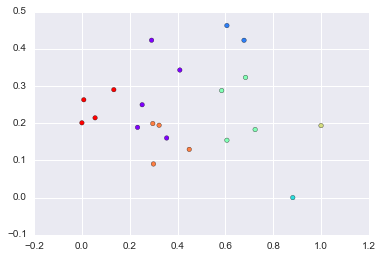

In [459]:
model = KMeans(n_clusters=7)

X = appliance_df.values
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow');

In [461]:
!pip install hdbscan

    100% |████████████████████████████████| 647kB 338kB/s 
  Running setup.py bdist_wheel for hdbscan ... - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /Users/nipunbatra/Library/Caches/pip/wheels/7f/29/17/ab89e44a68f303481f4c362e035b3b7bbe512b6086268a8f96
Successfully built hdbscan


In [486]:
import hdbscan
appliance="wm"
appliance_df = df.ix[all_homes[appliance]][best_features[appliance]]
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
cluster_labels = clusterer.fit_predict(appliance_df)

In [487]:
cluster_labels

array([ 0,  1, -1,  1,  1, -1,  1,  1,  1,  0,  1,  1, -1,  0,  1,  1])

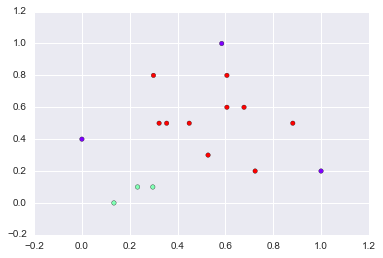

In [488]:
plt.scatter(appliance_df.values[:,0],appliance_df.values[:,1],c=cluster_labels, cmap='rainbow')

In [508]:
score = {}
for appliance in all_homes.keys():
    np.random.seed(42)
    print appliance
    score[appliance]={}
    dfa = df.ix[all_homes[appliance]][best_features[appliance]]
    clf = hdbscan.HDBSCAN(min_cluster_size=3)
    clf.fit(dfa)
    labels = clf.labels_
    labels_to_use = [x for x in set(labels) if x!=-1]
    o = {}
    for label in labels_to_use:
        o[label]=dfa.ix[dfa.groupby(labels).groups[label]].median()
    centroids = pd.DataFrame(o).T
    

    for home in dfa.index:
        di = np.sqrt(np.square(centroids-dfa.ix[home]).sum(axis=1))
        cluster_closest = di.argmin()
        distance = di.ix[cluster_closest]
        #score[appliance][home] = (1.0/(distance+0.1))
        score[appliance][home] = (1.0/(distance+0.1))*(len(all_homes[appliance])/(count_to_use.ix[cluster_closest])*0.5)
    score[appliance] = pd.Series(score[appliance])
    score[appliance].sort()
    score[appliance]=scale_min_max(score[appliance],0,1)

hvac
light
wm
fridge
dw
dr


In [537]:
train_homes = np.array(a.tail(7).index.tolist())
test_homes = np.array([x for x in a.index if x not in train_homes])

In [538]:
predict_train_homes(train_homes, test_homes, "hvac", "Monthly")

(70.343980303881168,
              5          6          7          8          9          10
 5357  34.803265  62.565581  50.972474  61.029062  37.382972  25.913941
 2242  41.579291  65.207518  58.187497  70.227396  55.758775  47.922650
 9922   0.000000  48.230113  72.451163  88.006184  82.653405  48.946836
 370   84.843412  99.147036  84.470109  79.741386  58.434718  41.360766
 3367  80.574877  98.127752  78.772524  89.633685  62.926807  49.131935
 3723  73.235587  36.930268  19.327641  63.376646  84.080979  54.320742
 2156  53.114995  99.840370  99.230103  94.704093  97.703313  55.974822
 2129  67.902705  97.548295  84.313762  98.576835  69.044228  46.412418
 2814  83.322483  96.270364  81.858559  85.282335  59.781835  61.159998
 5371  67.261593  83.583060  83.547071  86.595737  85.758310  96.256908
 545   61.574490  84.653022  79.048420  81.338964  64.638899  40.851819
 7731  92.983019  66.016632  89.537655  86.881664  77.402718  69.718756
 1283  62.947517  40.153842  96.314786  76.

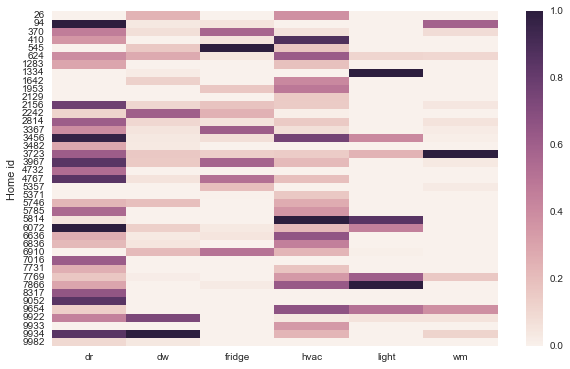

In [550]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(score).fillna(0))
plt.ylabel("Home id")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/score.png")

In [547]:
pd.DataFrame(score).median()

dr        0.416840
dw        0.105785
fridge    0.138538
hvac      0.232823
light     0.428111
wm        0.058081
dtype: float64

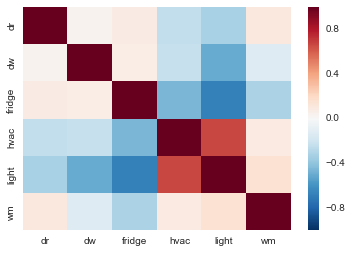

In [553]:
sns.heatmap(pd.DataFrame(score).corr())
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/score_heatmap.png")